In [1]:
import os
import re
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import metrics

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [3]:
df = pd.read_csv('data/RealEstateDataForMLModel.csv')
df.head()

,Property_Type,Club_House,School_University_In_Township,Hospital_In_Township,Mall_In_Township,Park_Jogging_Track,Swimming_Pool,Gym,Property_Area_in_SqFt,Price_In_Lakhs,Price_By_SubArea,Amenities_Score,Price_By_Amenities_Score,Noun_Counts,Verb_Counts,Adjective_Counts,boasts_elegant,elegant_towers,every_day,great_community,mantra_gold,offering_bedroom,quality_specification,stories_offering,towers_stories,world_class
0,1.0,1,1,1,1,1,1,1,492.0,39.0,58.044000,7,72.666667,9,1,3,0,0,0,0,0,0,0,0,0,0
1,2.0,1,1,1,1,1,1,1,774.0,65.0,58.044000,7,72.666667,9,1,3,0,0,0,0,0,0,0,0,0,0
2,3.0,1,1,1,1,1,1,1,889.0,74.0,58.044000,7,72.666667,9,1,3,0,0,0,0,0,0,0,0,0,0
3,3.0,1,1,1,1,1,1,1,1018.0,89.0,58.044000,7,72.666667,8,1,3,0,0,0,0,0,0,0,0,0,0
4,2.0,1,1,1,1,1,1,1,743.0,74.0,73.555556,7,72.666667,12,1,6,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Property_Type                  199 non-null    float64
 1   Club_House                     199 non-null    int64  
 2   School_University_In_Township  199 non-null    int64  
 3   Hospital_In_Township           199 non-null    int64  
 4   Mall_In_Township               199 non-null    int64  
 5   Park_Jogging_Track             199 non-null    int64  
 6   Swimming_Pool                  199 non-null    int64  
 7   Gym                            199 non-null    int64  
 8   Property_Area_in_SqFt          199 non-null    float64
 9   Price_In_Lakhs                 199 non-null    float64
 10  Price_By_SubArea               199 non-null    float64
 11  Amenities_Score                199 non-null    int64  
 12  Price_By_Amenities_Score       199 non-null    flo

### Helper function to calculate prediction interval:

In [38]:
pi=0.50
one_minus_pi = 1 - pi
ppf_lookup = 1 - (one_minus_pi / 2) # If we need to calculate a 'Two-tail test' (i.e. We're concerned with values both greater and less than our mean) then we need to split the significance (i.e. our alpha value) because we're still using a calculation method for one-tail. The split in half symbolizes the significance level being appropriated to both tails. A 95% significance level has a 5% alpha; splitting the 5% alpha across both tails returns 2.5%. Taking 2.5% from 100% returns 97.5% as an input for the significance level.
z_score = stats.norm.ppf(ppf_lookup) # This will return a value (that functions as a 'standard-deviation multiplier') marking where 95% (pi%) of data points would be contained if our data is a normal distribution.
z_score

0.6744897501960817

In [6]:
def get_interval(train_actual_values, train_predicted_values, pi=.60):
    '''
    Get a prediction interval for the regression model.
    
    INPUTS: 
        - actual_values (y_train)
        - predicted_values (prediction from x_train)
        - Prediction interval threshold (default = .95) 
    OUTPUT: 
        - Interval estimate
    '''
    
    #get standard deviation of prediction on the train dataset
    sum_of_square_error = np.sum((train_actual_values - train_predicted_values)**2)
    stdev = np.sqrt(sum_of_square_error / (len(train_actual_values) - 1))
    
    #get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2) # If we need to calculate a 'Two-tail test' (i.e. We're concerned with values both greater and less than our mean) then we need to split the significance (i.e. our alpha value) because we're still using a calculation method for one-tail. The split in half symbolizes the significance level being appropriated to both tails. A 95% significance level has a 5% alpha; splitting the 5% alpha across both tails returns 2.5%. Taking 2.5% from 100% returns 97.5% as an input for the significance level.
    z_score = stats.norm.ppf(ppf_lookup) # This will return a value (that functions as a 'standard-deviation multiplier') marking where 95% (pi%) of data points would be contained if our data is a normal distribution.
    interval_value = z_score * stdev
    
    return interval_value

In [7]:
def get_prediction_interval(y_predicted_value, interval_value):
    
    #generate prediction interval lower and upper bound cs_24
    lower, upper = y_predicted_value - interval_value, y_predicted_value + interval_value
    return lower, upper

### Split the dataset into Train and Test

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('Price_In_Lakhs',axis =1)
Y = df['Price_In_Lakhs']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.30, random_state=1234)
print(f'Shape of Training DataSet- X_train {X_train.shape} and X_test {X_test.shape}')
print(f'Shape of Training DataSet- Y_train {Y_train.shape} and Y_test {Y_test.shape}')

Shape of Training DataSet- X_train (139, 25) and X_test (60, 25)
Shape of Training DataSet- Y_train (139,) and Y_test (60,)


## I. Linear Regression Model

In [9]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(X_train, Y_train)

y_predict_train = linear_regression.predict(X_train)

print(f'R2 Score for Training Dataset is {metrics.r2_score(Y_train,y_predict_train)}')
print(f'MSE for Training Dataset is {metrics.mean_absolute_error(Y_train, y_predict_train)}')
print(f'RMSE Score for Training Dataset is {np.sqrt(metrics.mean_squared_error(Y_train, y_predict_train))}')

y_predict_test = linear_regression.predict(X_test)

print(f'\n\nR2 Score for Test Dataset is {metrics.r2_score(Y_test,y_predict_test)}')
print(f'MSE for Test Dataset is {metrics.mean_absolute_error(Y_test, y_predict_test)}')
print(f'RMSE Score for Test Dataset is {np.sqrt(metrics.mean_squared_error(Y_test, y_predict_test))}')

R2 Score for Training Dataset is 0.848365738533305
MSE for Training Dataset is 12.495060055272702
RMSE Score for Training Dataset is 17.65970755810552


R2 Score for Test Dataset is 0.8930631464821581
MSE for Test Dataset is 11.578040946978572
RMSE Score for Test Dataset is 13.817382996596846


In [10]:
pd.DataFrame(zip(linear_regression.coef_.T, X_train.columns))

,0,1
0,14.184710,Property_Type
1,-17.078701,Club_House
2,2.571089,School_University_In_Township
3,2.571089,Hospital_In_Township
4,2.571089,Mall_In_Township
5,19.857640,Park_Jogging_Track
6,-7.232986,Swimming_Pool
7,-0.828347,Gym
8,0.057161,Property_Area_in_SqFt
9,0.464392,Price_By_SubArea


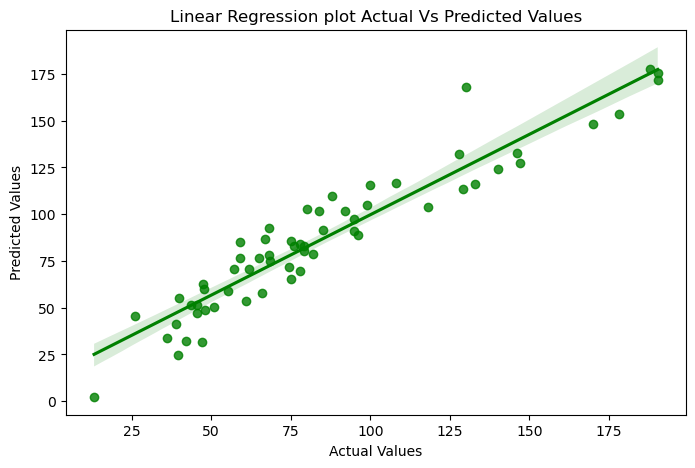

In [11]:
plt.figure(figsize=(8,5))
sns.regplot(x=Y_test, y= y_predict_test, color='green')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression plot Actual Vs Predicted Values')
plt.show()

In [12]:
# getting prediction intervals for the test data
lower_limit_prediction = []
upper_limit_prediction = []

interval_value = get_interval(Y_train.values, y_predict_train)

print(interval_value)

for i in y_predict_test:
    lvalue, uvalue = get_prediction_interval(i, interval_value)
    lower_limit_prediction.append(lvalue)
    upper_limit_prediction.append(uvalue)


14.916538325679038


In [13]:
df_linear = pd.DataFrame(zip(y_predict_test, lower_limit_prediction, upper_limit_prediction), columns=['Mean','LowerLimit','UpperLimit'])
print(df_linear.shape)
df_linear.head(20)

(60, 3)


,Mean,LowerLimit,UpperLimit
0,97.170051,82.253513,112.086590
1,101.612319,86.695781,116.528857
2,82.728806,67.812268,97.645344
3,132.139669,117.223131,147.056207
4,65.335868,50.419329,80.252406
5,101.771328,86.854789,116.687866
6,90.817211,75.900673,105.733749
7,115.867630,100.951091,130.784168
8,47.166069,32.249531,62.082608
9,51.315316,36.398777,66.231854


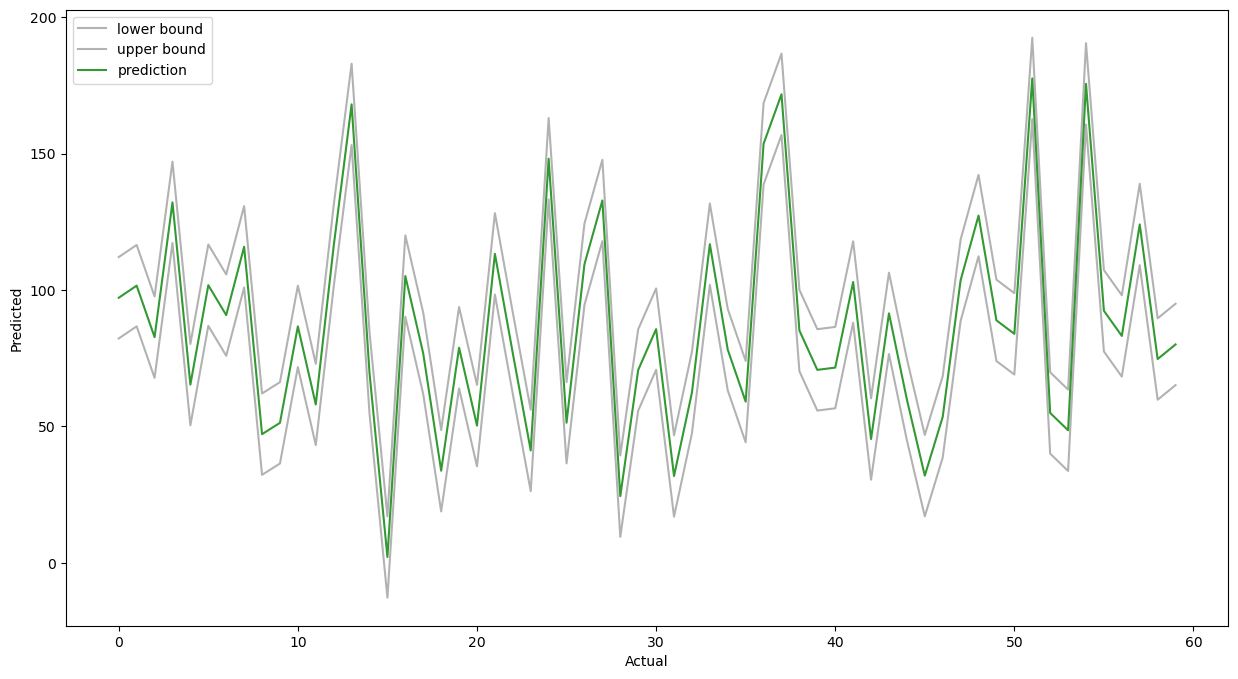

In [14]:
# Plotting the predicted and actual data 
plt.figure(figsize=(15,8))
plt.plot(lower_limit_prediction,label='lower bound',alpha=0.6,color='grey')
plt.plot(upper_limit_prediction,label='upper bound',alpha=0.6,color='grey')
plt.plot(y_predict_test,label='prediction',alpha=0.8,color='g')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.show()

## Ridge Regression Model

In [15]:
from sklearn.linear_model import Ridge

ridge_regression = Ridge()
ridge_regression.fit(X_train,Y_train)

y_predict_ridge_train = ridge_regression.predict(X_train)
print(f'R2 Score for Training Dataset is {metrics.r2_score(Y_train,y_predict_ridge_train)}')
print(f'MSE for Training Dataset is {metrics.mean_absolute_error(Y_train, y_predict_ridge_train)}')
print(f'RMSE Score for Training Dataset is {np.sqrt(metrics.mean_squared_error(Y_train, y_predict_ridge_train))}')

y_predict_ridge_test = ridge_regression.predict(X_test)

print(f'\n\nR2 Score for Test Dataset is {metrics.r2_score(Y_test,y_predict_ridge_test)}')
print(f'MSE for Test Dataset is {metrics.mean_absolute_error(Y_test, y_predict_ridge_test)}')
print(f'RMSE Score for Test Dataset is {np.sqrt(metrics.mean_squared_error(Y_test, y_predict_ridge_test))}')

R2 Score for Training Dataset is 0.8474371406879109
MSE for Training Dataset is 12.549694754973334
RMSE Score for Training Dataset is 17.71369844572185


R2 Score for Test Dataset is 0.8955488647695424
MSE for Test Dataset is 11.540452892159019
RMSE Score for Test Dataset is 13.655848099936316


In [16]:
pd.DataFrame(zip(ridge_regression.coef_.T, X_train.columns))

,0,1
0,13.731420,Property_Type
1,-14.628386,Club_House
2,3.584053,School_University_In_Township
3,3.584053,Hospital_In_Township
4,3.584053,Mall_In_Township
5,10.138887,Park_Jogging_Track
6,-5.158698,Swimming_Pool
7,-0.090993,Gym
8,0.057277,Property_Area_in_SqFt
9,0.470513,Price_By_SubArea


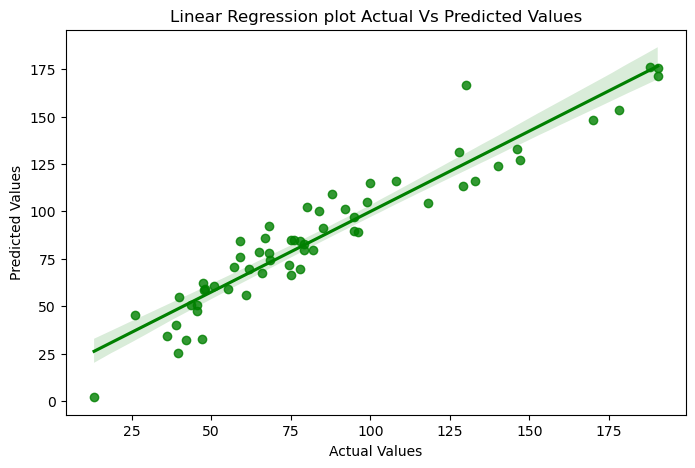

In [17]:
plt.figure(figsize=(8,5))
sns.regplot(x=Y_test, y= y_predict_ridge_test, color='green')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression plot Actual Vs Predicted Values')
plt.show()

In [18]:
# getting prediction intervals for the test data
lower_limit_prediction = []
upper_limit_prediction = []

interval_value = get_interval(Y_train.values, y_predict_ridge_train)

print(interval_value)

for i in y_predict_ridge_test:
    lvalue, uvalue = get_prediction_interval(i, interval_value)
    lower_limit_prediction.append(lvalue)
    upper_limit_prediction.append(uvalue)


14.962142543173387


In [19]:
df_ridge = pd.DataFrame(zip(y_predict_ridge_test, lower_limit_prediction, upper_limit_prediction), columns=['Mean','LowerLimit','UpperLimit'])
print(df_ridge.shape)
df_ridge.head(20)

(60, 3)


,Mean,LowerLimit,UpperLimit
0,96.982552,82.020410,111.944695
1,101.477138,86.514995,116.439280
2,84.712288,69.750145,99.674430
3,131.342863,116.380721,146.305006
4,66.491129,51.528986,81.453272
5,100.244045,85.281902,115.206187
6,89.560076,74.597933,104.522219
7,114.884679,99.922536,129.846822
8,47.615549,32.653406,62.577691
9,50.833312,35.871170,65.795455


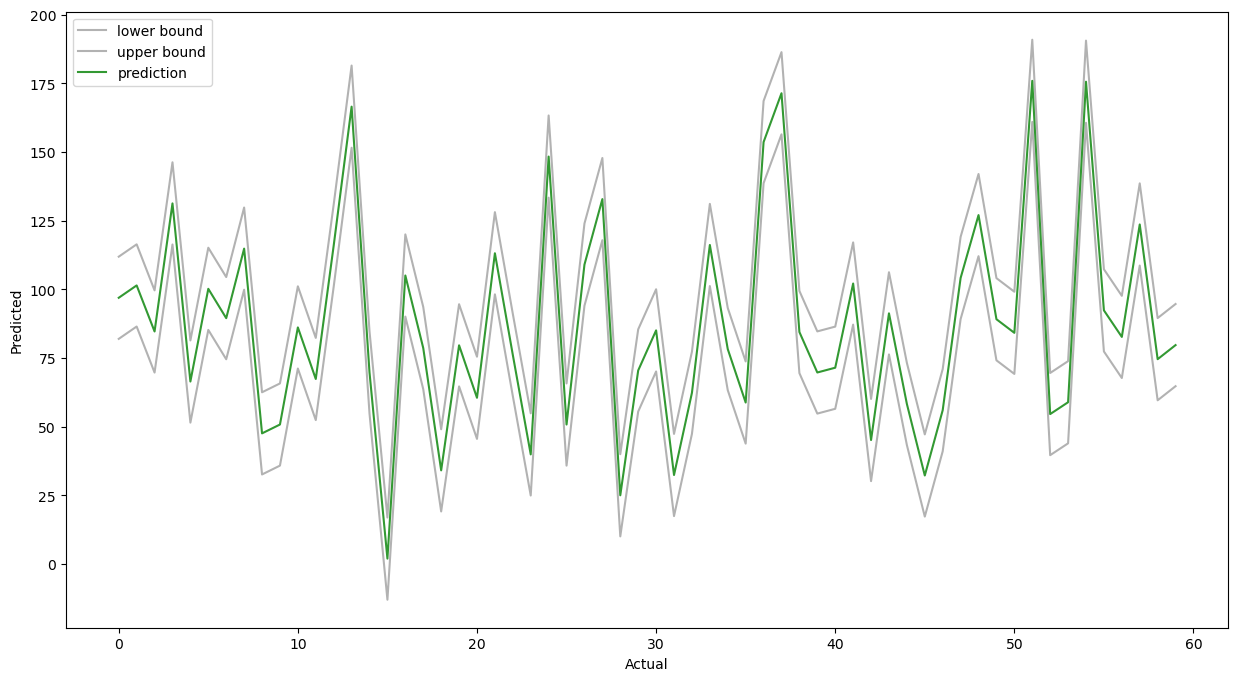

In [20]:
# Plotting the predicted and actual data 
plt.figure(figsize=(15,8))
plt.plot(lower_limit_prediction,label='lower bound',alpha=0.6,color='grey')
plt.plot(upper_limit_prediction,label='upper bound',alpha=0.6,color='grey')
plt.plot(y_predict_ridge_test,label='prediction',alpha=0.8,color='g')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.show()

## Lasso Regression Model

In [21]:
from sklearn.linear_model import Lasso

lasso_regression = Lasso()
lasso_regression.fit(X_train,Y_train)

y_predict_lasso_train = lasso_regression.predict(X_train)
print(f'R2 Score for Training Dataset is {metrics.r2_score(Y_train,y_predict_lasso_train)}')
print(f'MSE for Training Dataset is {metrics.mean_absolute_error(Y_train, y_predict_lasso_train)}')
print(f'RMSE Score for Training Dataset is {np.sqrt(metrics.mean_squared_error(Y_train, y_predict_lasso_train))}')

y_predict_lasso_test = lasso_regression.predict(X_test)

print(f'\n\nR2 Score for Test Dataset is {metrics.r2_score(Y_test,y_predict_lasso_test)}')
print(f'MSE for Test Dataset is {metrics.mean_absolute_error(Y_test, y_predict_lasso_test)}')
print(f'RMSE Score for Test Dataset is {np.sqrt(metrics.mean_squared_error(Y_test, y_predict_lasso_test))}')

R2 Score for Training Dataset is 0.8322712927021247
MSE for Training Dataset is 12.53040815170207
RMSE Score for Training Dataset is 18.573277059034428


R2 Score for Test Dataset is 0.9144414208338018
MSE for Test Dataset is 10.256670797305842
RMSE Score for Test Dataset is 12.359300081411144


In [22]:
pd.DataFrame(zip(lasso_regression.coef_.T, X_train.columns))

,0,1
0,10.171359,Property_Type
1,-5.580468,Club_House
2,0.000000,School_University_In_Township
3,0.000000,Hospital_In_Township
4,0.000000,Mall_In_Township
5,0.000000,Park_Jogging_Track
6,-0.000000,Swimming_Pool
7,-0.000000,Gym
8,0.062600,Property_Area_in_SqFt
9,0.495792,Price_By_SubArea


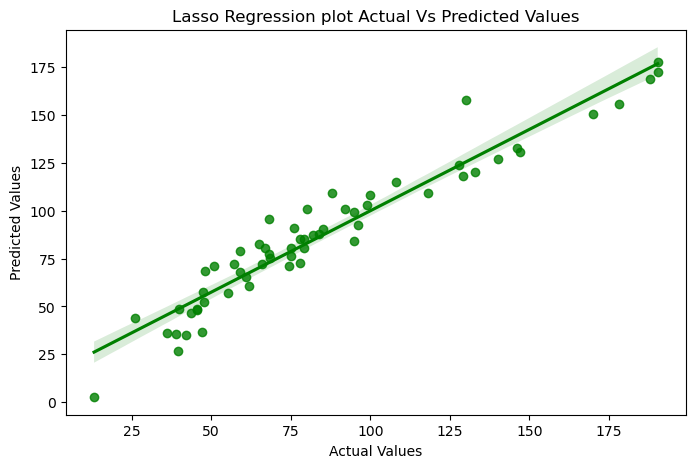

In [23]:
plt.figure(figsize=(8,5))
sns.regplot(x=Y_test, y= y_predict_lasso_test, color='green')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Lasso Regression plot Actual Vs Predicted Values')
plt.show()

In [24]:
# getting prediction intervals for the test data
lower_limit_prediction = []
upper_limit_prediction = []

interval_value = get_interval(Y_train.values, y_predict_lasso_train)

print(interval_value)

for i in y_predict_lasso_test:
    lvalue, uvalue = get_prediction_interval(i, interval_value)
    lower_limit_prediction.append(lvalue)
    upper_limit_prediction.append(uvalue)


15.688198582732552


In [25]:
df_lasso = pd.DataFrame(zip(y_predict_lasso_test, lower_limit_prediction, upper_limit_prediction), columns=['Mean','LowerLimit','UpperLimit'])
print(df_lasso.shape)
df_lasso.head(20)

(60, 3)


,Mean,LowerLimit,UpperLimit
0,99.295991,83.607793,114.984190
1,100.980277,85.292079,116.668476
2,91.038201,75.350002,106.726399
3,123.908722,108.220523,139.596921
4,76.316243,60.628044,92.004442
5,87.758646,72.070447,103.446845
6,84.145993,68.457795,99.834192
7,108.250846,92.562648,123.939045
8,48.841721,33.153522,64.529919
9,46.815848,31.127650,62.504047


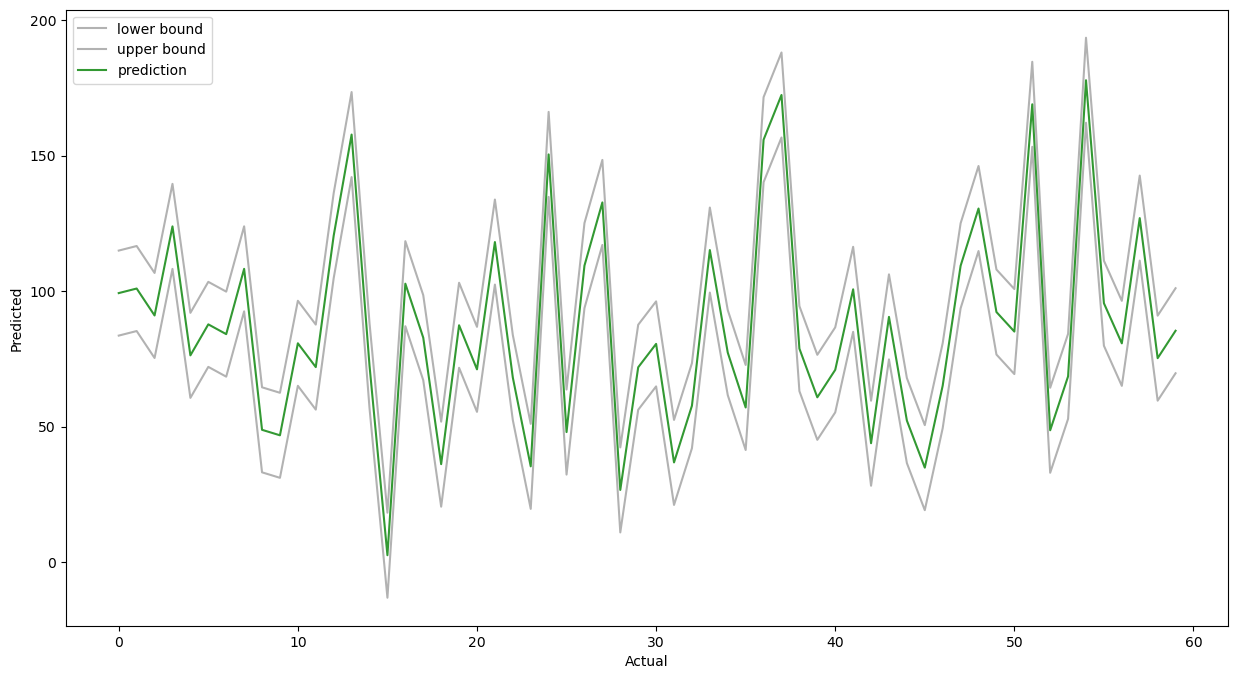

In [26]:
# Plotting the predicted and actual data 
plt.figure(figsize=(15,8))
plt.plot(lower_limit_prediction,label='lower bound',alpha=0.6,color='grey')
plt.plot(upper_limit_prediction,label='upper bound',alpha=0.6,color='grey')
plt.plot(y_predict_lasso_test,label='prediction',alpha=0.8,color='g')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.show()

## IV. Voting Regressor

In [27]:
from sklearn.ensemble import VotingRegressor

reg_estimator = [('lr',linear_regression),('rid',ridge_regression),('lasso',lasso_regression)]

voting_regressor = VotingRegressor(estimators=reg_estimator)
voting_regressor.fit(X_train, Y_train)

y_predict_voting_train = voting_regressor.predict(X_train)

print(f'R2 Score for Training Dataset is {metrics.r2_score(Y_train,y_predict_voting_train)}')
print(f'MSE for Training Dataset is {metrics.mean_absolute_error(Y_train, y_predict_voting_train)}')
print(f'RMSE Score for Training Dataset is {np.sqrt(metrics.mean_squared_error(Y_train, y_predict_voting_train))}')

y_predict_voting_test = voting_regressor.predict(X_test)

print(f'\n\nR2 Score for Test Dataset is {metrics.r2_score(Y_test,y_predict_voting_test)}')
print(f'MSE for Test Dataset is {metrics.mean_absolute_error(Y_test, y_predict_voting_test)}')
print(f'RMSE Score for Test Dataset is {np.sqrt(metrics.mean_squared_error(Y_test, y_predict_voting_test))}')

R2 Score for Training Dataset is 0.8458681602151502
MSE for Training Dataset is 12.421240163655597
RMSE Score for Training Dataset is 17.80455069081004


R2 Score for Test Dataset is 0.9057804583954902
MSE for Test Dataset is 10.820356697208076
RMSE Score for Test Dataset is 12.969779376136751


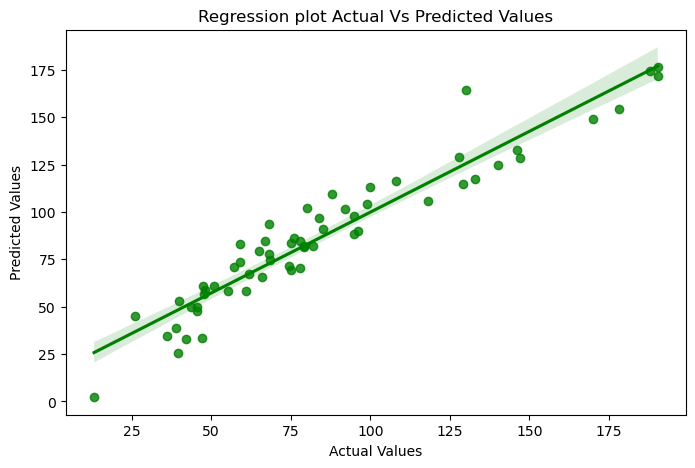

In [28]:
plt.figure(figsize=(8,5))
sns.regplot(x=Y_test, y= y_predict_voting_test, color='green')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Regression plot Actual Vs Predicted Values')
plt.show()

In [29]:
# getting prediction intervals for the test data
lower_limit_prediction = []
upper_limit_prediction = []

interval_value = get_interval(Y_train.values, y_predict_voting_train)

print(interval_value)

for i in y_predict_voting_test:
    lvalue, uvalue = get_prediction_interval(i, interval_value)
    lower_limit_prediction.append(lvalue)
    upper_limit_prediction.append(uvalue)


15.038882262184757


In [30]:
df_lasso = pd.DataFrame(zip(y_predict_voting_test, lower_limit_prediction, upper_limit_prediction), columns=['Mean','LowerLimit','UpperLimit'])
print(df_lasso.shape)
df_lasso.head(20)

(60, 3)


,Mean,LowerLimit,UpperLimit
0,97.816198,82.777316,112.855080
1,101.356578,86.317696,116.395460
2,86.159765,71.120883,101.198647
3,129.130418,114.091536,144.169300
4,69.381080,54.342198,84.419962
5,96.591340,81.552457,111.630222
6,88.174427,73.135544,103.213309
7,113.001052,97.962169,128.039934
8,47.874446,32.835564,62.913328
9,49.654825,34.615943,64.693708


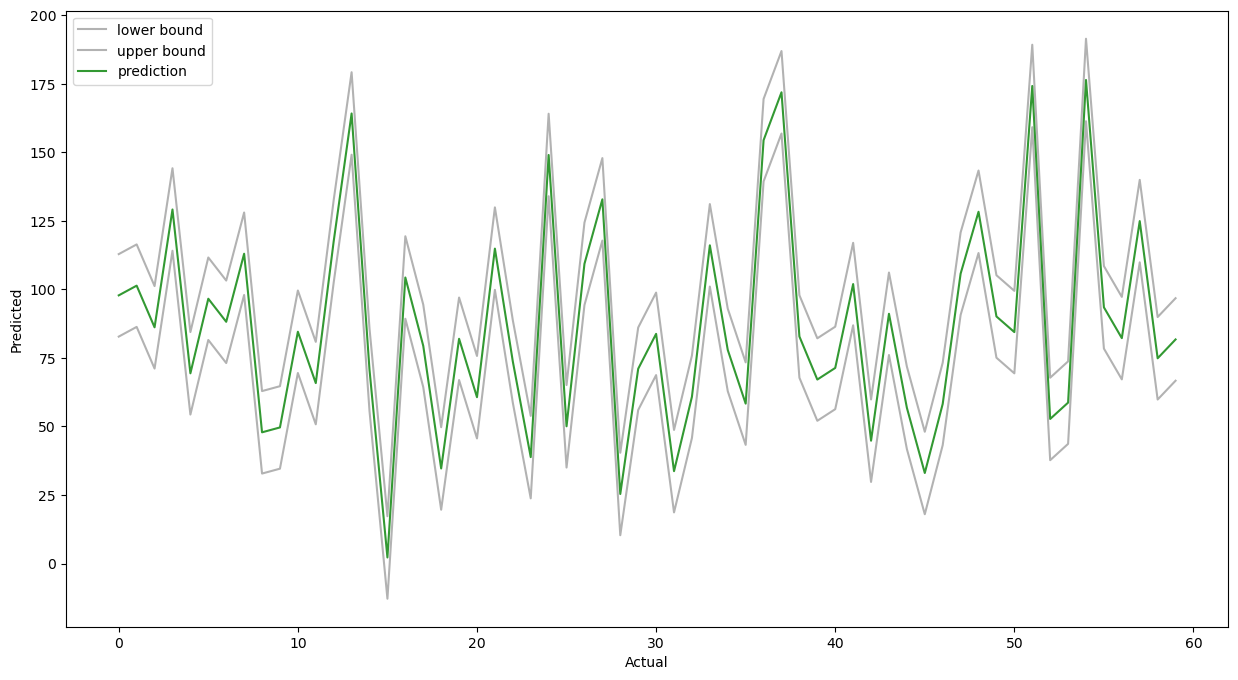

In [31]:
# Plotting the predicted and actual data 
plt.figure(figsize=(15,8))
plt.plot(lower_limit_prediction,label='lower bound',alpha=0.6,color='grey')
plt.plot(upper_limit_prediction,label='upper bound',alpha=0.6,color='grey')
plt.plot(y_predict_voting_test,label='prediction',alpha=0.8,color='g')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.show()

## Saving the final trained model:

In [32]:
# Getting the interval estimate for future test usage
interval_estimates = get_interval(Y_train.values, y_predict_voting_train)
print(interval_estimates)

import pickle
filename = 'model/estimating_interval.pkl'
with open(filename,'wb') as f:
    pickle.dump(interval_estimates,f)

15.038882262184757


In [33]:
import joblib

filename = 'model/property_price_prediction_model.sav'
joblib.dump(voting_regressor,filename) 

['model/property_price_prediction_model.sav']

In [34]:
# load the model from disk
import joblib

filename = 'model/property_price_prediction_model.sav'
loaded_model = joblib.load(filename)
print(loaded_model)

VotingRegressor(estimators=[('lr', LinearRegression()), ('rid', Ridge()),
                            ('lasso', Lasso())])


In [35]:
# testing it on the test data
result = loaded_model.score(X_test, Y_test)
print(result)

0.9057804583954902
